## Intro

This notebook contains an experimental use case of an efficient net style CNN that implements dilated convolutions, SE attention and spatial attention mechanisms. These additions enable the network to assess larger areas of inputed images, and enable the network to learn assign attention weights to channels (SE attention) and to specific spatial regions (spatial attention). These additions are advantageous in medical imaging classification tasks, such as brain tumor identification.

(Notebook was created in Google CoLab using a L4 GPU)

### Experiment Setup

In [1]:
# imports
import os
import random
import time
from pathlib import Path
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader

# seed setting
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

# setting device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)


Device: cuda


### EDA

Experiment dataset can be found on kaggle at...

https://www.kaggle.com/datasets/arwabasal/brain-tumor-mri-detection

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("arwabasal/brain-tumor-mri-detection")

path = path + "/brain_tumor_dataset"

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'brain-tumor-mri-detection' dataset.
Path to dataset files: /kaggle/input/brain-tumor-mri-detection/brain_tumor_dataset


In [3]:
DATA_DIR = path
classes = [folder for folder in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, folder))]
print('Available classes: ', classes)


Available classes:  ['no', 'yes']


In [4]:
import pandas as pd

data = []
for cls in classes:
    class_path = os.path.join(DATA_DIR, cls)
    for filename in os.listdir(class_path):
        filepath = os.path.join(class_path, filename)
        data.append({'filepath': filepath, 'label': cls})

df = pd.DataFrame(data)
df = df.sample(frac=1).reset_index(drop=True)

print("\n\nDataFrame Information:")
df.info()



DataFrame Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253 entries, 0 to 252
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filepath  253 non-null    object
 1   label     253 non-null    object
dtypes: object(2)
memory usage: 4.1+ KB


The dataset does contain a class imbalance, with the dataset containing more images of brains with tumors than images of brains without.

Stratified random sampling was used instead of random sampling in order to perserve class distribution.

In [5]:
print("\nClass Distribution:")
class_counts = df['label'].value_counts()

print(class_counts)


Class Distribution:
label
yes    155
no      98
Name: count, dtype: int64


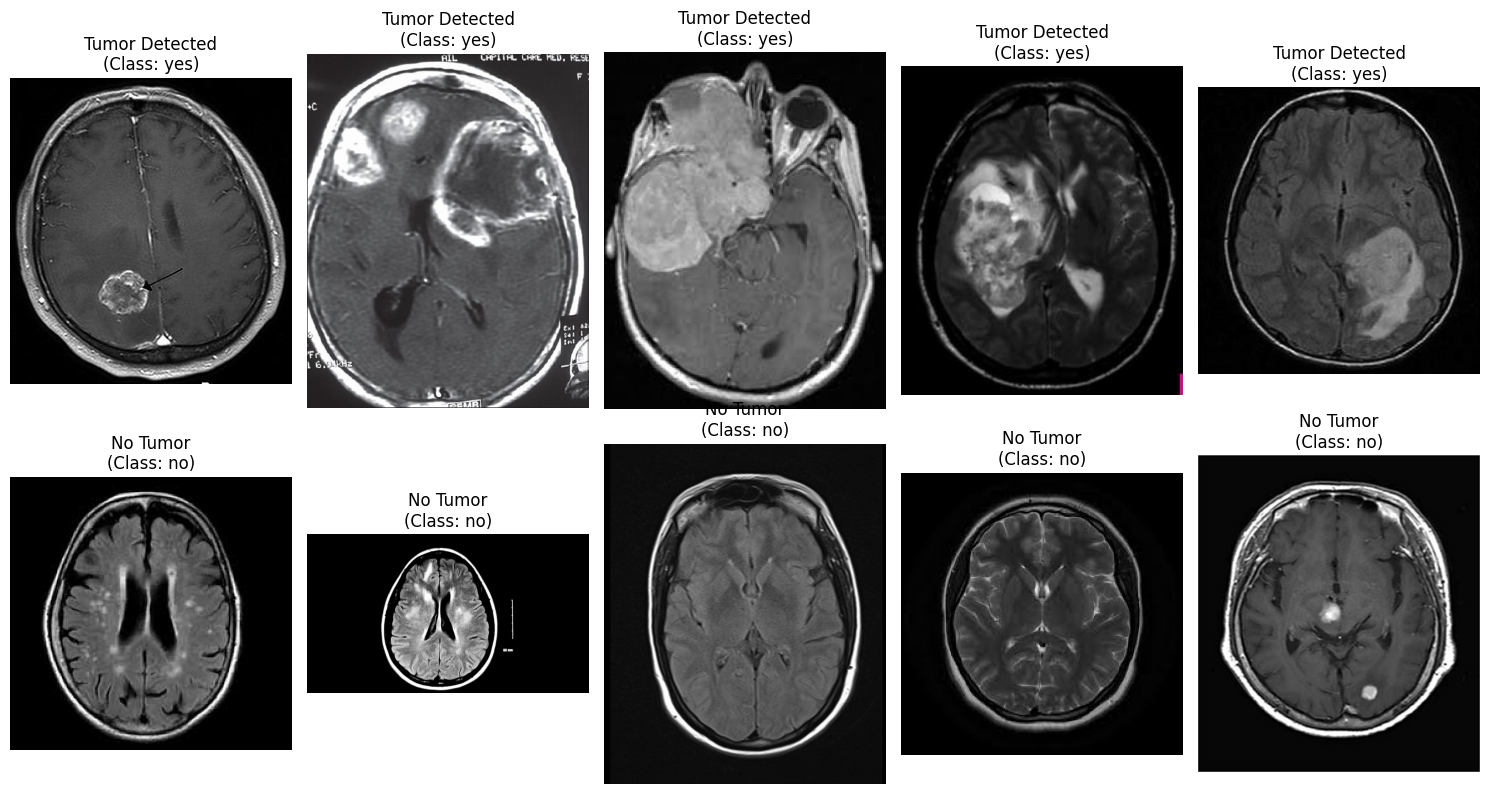

In [6]:
import cv2

plt.figure(figsize=(15, 8))
n_samples = 5
pos_samples = df[df['label'] == 'yes'].sample(n_samples)

for i, row in enumerate(pos_samples.iterrows()):
    filepath = row[1]['filepath']
    img = cv2.imread(filepath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(2, n_samples, i + 1)
    plt.imshow(img)
    plt.title(f"Tumor Detected\n(Class: yes)")
    plt.axis('off')


neg_samples = df[df['label'] == 'no'].sample(n_samples)
for i, row in enumerate(neg_samples.iterrows()):
    filepath = row[1]['filepath']
    img = cv2.imread(filepath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(2, n_samples, n_samples + i + 1)
    plt.imshow(img)
    plt.title(f"No Tumor\n(Class: no)")
    plt.axis('off')

plt.tight_layout()
plt.show()

From the images above, one can see that the images are different sizes and will need to be resized for training. All images will be resized to a size of 224x224 pixels for training.

Reading image dimensions: 100%|██████████| 253/253 [00:01<00:00, 157.55it/s]



Image Size Stats:


,height,width
count,253.000000,253.000000
mean,386.019763,354.237154
std,213.128463,217.111684
min,168.000000,150.000000
25%,248.000000,225.000000
50%,331.000000,278.000000
75%,442.000000,400.000000
max,1427.000000,1920.000000


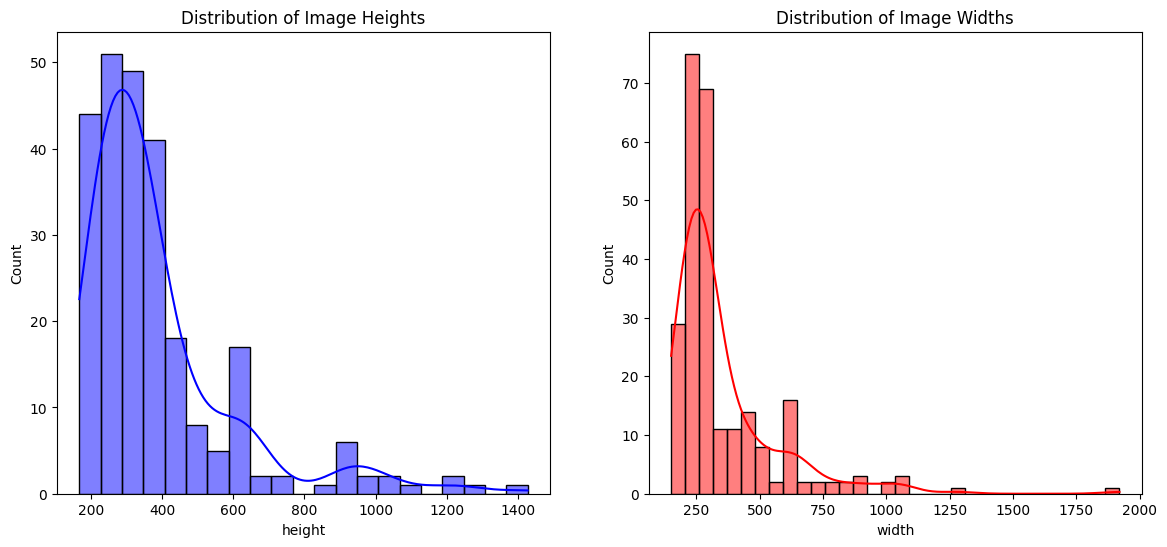

In [7]:
hgt = []
wdt = []

for filepath in tqdm(df['filepath'], desc="Reading image dimensions"):
    try:
        img = cv2.imread(filepath)
        h, w, _ = img.shape
        hgt.append(h)
        wdt.append(w)
    except Exception as e:
        print(f"Could not read {filepath}: {e}")

df['height'] = hgt
df['width'] = wdt

print("\nImage Size Stats:")
display(df[['height', 'width']].describe())

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(df['height'], kde=True, color='blue').set_title('Distribution of Image Heights')
plt.subplot(1, 2, 2)
sns.histplot(df['width'], kde=True, color='red').set_title('Distribution of Image Widths')
plt.show()

### Datasets & Loaders

In [8]:
import torchvision
import torchvision.transforms as transforms

# size
IMG_SIZE = 224

# batch size
BATCH_SIZE = 32

# mean/std for RGB images
BRAIN_MEAN = [0.485, 0.456, 0.406]
BRAIN_STD = [0.229, 0.224, 0.225]

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit

samplier = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_idx, val_idx in samplier.split(df['filepath'], df['label']):
    train_df = df.iloc[train_idx]
    val_df = df.iloc[val_idx]

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

print("Training data split:")
print(train_df['label'].value_counts(normalize=True))
print("\nValidation data split:")
print(val_df['label'].value_counts(normalize=True))

Training data split:
label
yes    0.613861
no     0.386139
Name: proportion, dtype: float64

Validation data split:
label
yes    0.607843
no     0.392157
Name: proportion, dtype: float64


In [10]:
training_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ElasticTransform(alpha = 1.0, sigma = 10.0),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize(BRAIN_MEAN, BRAIN_STD)
])

validation_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(BRAIN_MEAN, BRAIN_STD)
])

In [11]:
from torch.utils.data import Dataset, DataLoader
import cv2
import torchvision.transforms as transforms


class BrainTumorDataset(Dataset):
  def __init__(self, df, transform=None):
    self.df = df
    self.transform = transform
    self.labels = self.df['label'].map({'yes': 1, 'no': 0}).values

  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
    filepath = self.df.loc[index, 'filepath']
    label = self.labels[index]
    image = cv2.imread(filepath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    if self.transform:
        image = self.transform(image)

    return image, torch.tensor(label, dtype=torch.long)

Visualizing some of the applied augmentations on a single training image:


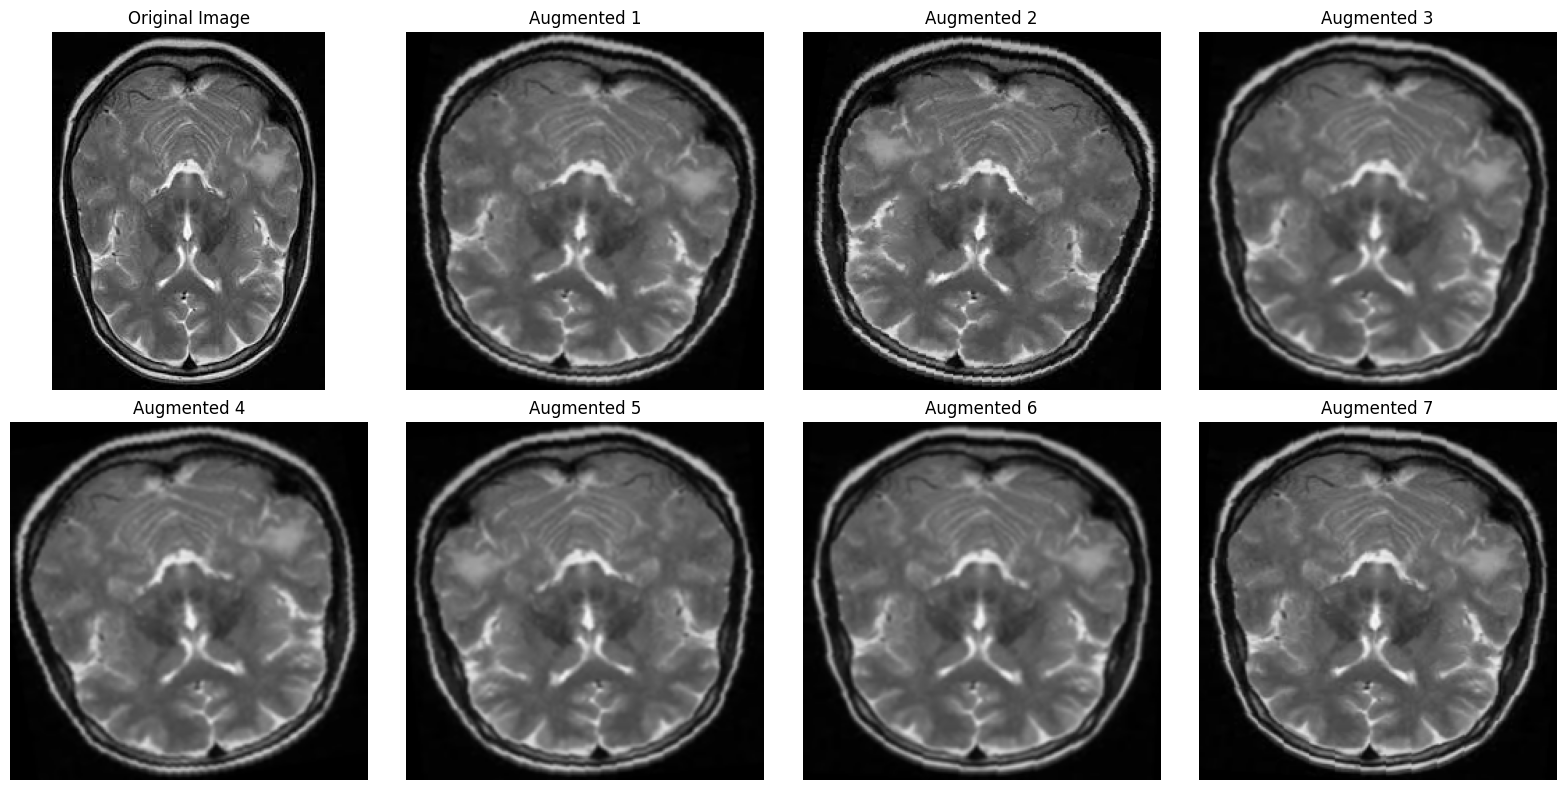

In [12]:
import numpy as np

temp_train_dataset = BrainTumorDataset(train_df, transform=training_transforms)
print("Visualizing some of the applied augmentations on a single training image:")

n_images = 8
original_image, _ = temp_train_dataset[0]
# Remove Normalize and ToTensor for visualization
viz_transforms = transforms.Compose([t for t in temp_train_dataset.transform.transforms if not isinstance(t, (transforms.Normalize, transforms.ToTensor))])

raw_img = cv2.imread(temp_train_dataset.df.loc[0, 'filepath'])
raw_img = cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(16, 8))
plt.subplot(2, (n_images + 1) // 2, 1)
plt.imshow(raw_img)
plt.title("Original Image")
plt.axis('off')

for i in range(1, n_images):
    augmented = viz_transforms(raw_img)
    # Convert PIL Image to numpy array for displaying
    augmented = np.array(augmented)
    plt.subplot(2, (n_images + 1) // 2, i + 1)
    plt.imshow(augmented)
    plt.title(f"Augmented {i}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [13]:
train_dataset = BrainTumorDataset(train_df, transform=training_transforms)
val_dataset = BrainTumorDataset(val_df, transform=validation_transforms)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"\nNumber of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")

images, labels = next(iter(train_loader))
print(f"\nShape of one batch of images: {images.shape}")
print(f"Shape of one batch of labels: {labels.shape}")


Number of training batches: 7
Number of validation batches: 2

Shape of one batch of images: torch.Size([32, 3, 224, 224])
Shape of one batch of labels: torch.Size([32])


### Model

The augmented model is inspired by the efficientNet design; however, it will include channel and spatial attention mechanisms, along with dilated convolutions.

SE and spatial attention blocks are defined first to be used in the primary network block later.

In [14]:
# building blocks
class SEblock(nn.Module):
  """Squeeze-and-Excitation block"""
  def __init__(self, in_channels, reduction_ratio=16, dropout_rate=0.0):
    super(SEblock, self).__init__()

    self.squeeze = nn.AdaptiveAvgPool2d(1)
    self.excitation = nn.Sequential(
        nn.Linear(in_channels, in_channels // reduction_ratio),
        nn.ReLU(inplace=True),
        nn.Linear(in_channels // reduction_ratio, in_channels, bias=False),
        nn.Sigmoid(),
        nn.Dropout(dropout_rate) # Added dropout
    )

  def forward(self, x):
    batch_size, channels, _, _ = x.size()

    y = self.squeeze(x).view(batch_size, channels)

    y = self.excitation(y).view(batch_size, channels, 1, 1)

    return x * y.expand_as(x)

class SpatialAttention(nn.Module):
  """Spatial attention module"""
  def __init__(self, kernal_size=7, dropout_rate=0.0):
    super(SpatialAttention, self).__init__()

    padding = kernal_size // 2
    self.conv = nn.Conv2d(2, 1, kernel_size=kernal_size, padding=padding, bias=False)
    self.sigmoid = nn.Sigmoid()
    self.dropout = nn.Dropout(dropout_rate) # Added dropout

  def forward(self, x):

    # Channel-wise
    avg_out = torch.mean(x, dim=1, keepdim=True)
    max_out, _ = torch.max(x, dim=1, keepdim=True)

    # Spatial Attention
    attention_input = torch.cat([avg_out, max_out], dim=1)
    attention_weights = self.sigmoid(self.conv(attention_input))
    attention_weights = self.dropout(attention_weights) # Applied dropout

    return x * attention_weights

To maintain computational efficiency, the network follows the paradigms of efficientNet and leverages both inverted bottlenecks and depthwise separable convolutions. Note that the depthwise separable convolutions have been modified to be dilated.

In [15]:
# Main block
class MedicalEfficientBlock(nn.Module):
    """
    EfficientNet-inspired block for medical imaging with:
    - Mobile inverted bottleneck
    - Depthwise separable convolutions
    - SE attention
    - Spatial attention
    - Dilated convolutions for larger receptive field
    """
    def __init__(self, in_channels, out_channels, expand_ratio=6,
                 stride=1, dilation=1, se_reduction=4):
        super(MedicalEfficientBlock, self).__init__()

        hidden_dim = int(in_channels * expand_ratio)
        self.use_residual = stride == 1 and in_channels == out_channels

        layers = []

        # Expansion phase
        if expand_ratio != 1:
          layers.extend([
              nn.Conv2d(in_channels, hidden_dim, 1, bias=False),
              nn.BatchNorm2d(hidden_dim),
              nn.ReLU6(inplace=True)
          ])

        # Depthwise dilated convolution
        padding = dilation * (3 - 1) // 2

        layers.extend([
            nn.Conv2d(hidden_dim, hidden_dim, 3, stride=stride, padding=padding,
                      dilation=dilation, groups=hidden_dim, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU6(inplace=True)
        ])

        self.conv_layers = nn.Sequential(*layers)

        # Squeeze-and-Excitation (channel attention)
        self.se_block = SEblock(hidden_dim, reduction_ratio=se_reduction, dropout_rate=0.0)

        # Spatial Attention
        self.spatial_attention = SpatialAttention(kernal_size=7, dropout_rate=0.0)

        # Pointwise Projection
        self.project = nn.Sequential(
            nn.Conv2d(hidden_dim, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
      # Inverted bottleneck
      out = self.conv_layers(x)

      # Channel attention
      out = self.se_block(out)

      # Spatial attention
      out = self.spatial_attention(out)

      # Pointwise projection
      out = self.project(out) # Apply the projection

      # Residual connetion
      if self.use_residual:
        out += x

      return out # Return the output

In [16]:
class BrainMRINet(nn.Module):
    """
    Complete EfficientNet-inspired architecture for brain MRI tumor detection
    """
    def __init__(self, num_classes=2, width_multiplier=1.0, depth_multiplier=1.0):
        super(BrainMRINet, self).__init__()

        def make_divisible(v, divisor=8):
            return max(divisor, int(v + divisor / 2) // divisor * divisor)

        # Input stem
        input_channels = make_divisible(32 * width_multiplier)
        # Change input channels to 3 for RGB images
        self.stem = nn.Sequential(
            nn.Conv2d(3, input_channels, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(input_channels),
            nn.ReLU6(inplace=True)
        )

        # EfficientNet-style stage configuration
        # [expand_ratio, channels, repeats, stride, dilation]
        stage_configs = [
            [1, 16, 1, 1, 1],    # Stage 1
            [6, 24, 2, 2, 1],    # Stage 2
            [6, 40, 2, 2, 1],    # Stage 3
            [6, 80, 3, 2, 2],    # Stage 4 (with dilation)
            [6, 112, 3, 1, 2],   # Stage 5 (with dilation)
            [6, 192, 4, 1, 4],   # Stage 6 (with high dilation)
        ]

        self.stages = nn.ModuleList()

        for expand_ratio, channels, repeats, stride, dilation in stage_configs:
            output_channels = make_divisible(channels * width_multiplier)
            stage_repeats = int(repeats * depth_multiplier)

            stage_layers = []

            for i in range(stage_repeats):
                stage_stride = stride if i == 0 else 1
                stage_layers.append(
                    MedicalEfficientBlock(
                        input_channels, output_channels,
                        expand_ratio=expand_ratio,
                        stride=stage_stride,
                        dilation=dilation
                    )
                )
                input_channels = output_channels

            self.stages.append(nn.Sequential(*stage_layers))

        # Head
        final_channels = make_divisible(1280 * width_multiplier)
        self.head_conv = nn.Sequential(
            nn.Conv2d(input_channels, final_channels, 1, bias=False),
            nn.BatchNorm2d(final_channels),
            nn.ReLU6(inplace=True)
        )

        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Dropout(0.75),
            nn.Linear(final_channels, num_classes)
        )

    def forward(self, x):
        x = self.stem(x)

        for stage in self.stages:
            x = stage(x)

        x = self.head_conv(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)

        return x

The network has a total of 5.6 million trainable parameters. This is slightly larger than a base MobileNetModel; however, is much smaller than ResNet18 which contains approximately 11.4 million parameters.

In [17]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Instantiate model
model = BrainMRINet(num_classes=2).to(device)
print('Model:', model.__class__.__name__)
print('Trainable params:', count_parameters(model))

# Dummy forward with CIFAR-sized batch (batch=8, 1x32x32)
x = torch.randn(8, 3, 32, 32, device=device) # Changed channels from 3 to 1
with torch.no_grad():
    out = model(x)
print('Output shape (batch x classes):', out.shape)
assert out.shape == (8, 2), 'Unexpected output shape — check model implementation.'

Model: BrainMRINet
Trainable params: 5603424
Output shape (batch x classes): torch.Size([8, 2])


In [18]:
train_dataset = BrainTumorDataset(train_df, transform=training_transforms)
val_dataset = BrainTumorDataset(val_df, transform=validation_transforms)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("Train DataLoader:", len(train_loader), "batches")
print("Validation DataLoader:", len(val_loader), "batches")

Train DataLoader: 7 batches
Validation DataLoader: 2 batches


### Training

In [19]:

def accuracy(output, target):
    """Compute accuracy (scalar)."""
    preds = output.argmax(dim=1)
    return (preds == target).float().mean().item()

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    running_acc = 0.0
    total = 0
    for images, targets in loader:
        images = images.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        batch_size = images.size(0)
        running_loss += loss.item() * batch_size
        running_acc += (outputs.argmax(1) == targets).sum().item()
        total += batch_size

    epoch_loss = running_loss / total
    epoch_acc = running_acc / total
    return epoch_loss, epoch_acc

@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_acc = 0.0
    total = 0
    for images, targets in loader:
        images = images.to(device)
        targets = targets.to(device)

        outputs = model(images)
        loss = criterion(outputs, targets)

        batch_size = images.size(0)
        running_loss += loss.item() * batch_size
        running_acc += (outputs.argmax(1) == targets).sum().item()
        total += batch_size

    eval_loss = running_loss / total
    eval_acc = running_acc / total
    return eval_loss, eval_acc


In [20]:
from torch.optim.lr_scheduler import CosineAnnealingLR

def fit(model, train_loader, test_loader, device, epochs=20, lr=0.01, weight_decay=3e-5):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader) * epochs, eta_min=1e-6)

    history = {'epoch': [], 'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': [], 'time': []}
    best_acc = 0.0
    best_path = Path('net_best.pth')

    for epoch in range(1, epochs + 1):
        t0 = time.time()
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
        test_loss, test_acc = evaluate(model, test_loader, criterion, device)
        scheduler.step()

        dt = time.time() - t0
        history['epoch'].append(epoch)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['test_loss'].append(test_loss)
        history['test_acc'].append(test_acc)
        history['time'].append(dt)

        print(f"Epoch {epoch:02d}/{epochs} - train_loss: {train_loss:.4f} acc: {100*train_acc:.2f}% | " +
              f"test_loss: {test_loss:.4f} acc: {100*test_acc:.2f}% | {dt:.1f}s")

        # Save best model
        if test_acc > best_acc:
            best_acc = test_acc
            torch.save(model.state_dict(), best_path)
            print(f"  -> Best model saved (acc: {100*best_acc:.2f}%).")

    return history, best_path

In [21]:

# Instantiate a fresh model for training
model = BrainMRINet(num_classes=2, width_multiplier=0.5, depth_multiplier=0.5)

history, best_path = fit(model, train_loader, val_loader, device, epochs=50,
                         lr=0.0005, weight_decay=1e-6)

print('\nTraining finished. Best checkpoint:', best_path)


Epoch 01/50 - train_loss: 0.6731 acc: 56.93% | test_loss: 0.6839 acc: 60.78% | 10.6s
  -> Best model saved (acc: 60.78%).
Epoch 02/50 - train_loss: 0.5741 acc: 71.78% | test_loss: 0.6868 acc: 60.78% | 9.7s
Epoch 03/50 - train_loss: 0.4781 acc: 79.21% | test_loss: 0.6961 acc: 39.22% | 9.7s
Epoch 04/50 - train_loss: 0.4335 acc: 81.19% | test_loss: 0.6979 acc: 39.22% | 9.3s
Epoch 05/50 - train_loss: 0.4432 acc: 80.20% | test_loss: 0.7017 acc: 39.22% | 9.6s
Epoch 06/50 - train_loss: 0.4120 acc: 84.16% | test_loss: 0.6518 acc: 70.59% | 9.6s
  -> Best model saved (acc: 70.59%).
Epoch 07/50 - train_loss: 0.4305 acc: 81.19% | test_loss: 0.5639 acc: 76.47% | 9.7s
  -> Best model saved (acc: 76.47%).
Epoch 08/50 - train_loss: 0.3937 acc: 83.66% | test_loss: 0.4973 acc: 80.39% | 9.7s
  -> Best model saved (acc: 80.39%).
Epoch 09/50 - train_loss: 0.3728 acc: 83.17% | test_loss: 0.5057 acc: 82.35% | 9.5s
  -> Best model saved (acc: 82.35%).
Epoch 10/50 - train_loss: 0.3548 acc: 86.14% | test_loss: 

### Evaluation

The model is able to learn from the training dataset; however, there are clear signs of overfitting. The training loss converges and decreases, while the testing loss is far more unstable and show very little convergence.

Despite this, the model is fairly accurate, with a overall accuracy of 0.9. Note that the model is oversensitive to the positve class, and over classifies the "yes - has brain tumor" category. This is benefical because a network that is trying to identify severe medical ailments should be sensitive to them (the model was able to appropriately classify 94% of the "has brain tumor" MRI images).

Future work with this model should aim to try and find more images of healthy brains, and attempt to integrate more regularization into the model. Further tests should try implementing more or stronger dropout to the model's attention mechanisms or reduce the number of overall blocks the model has.  


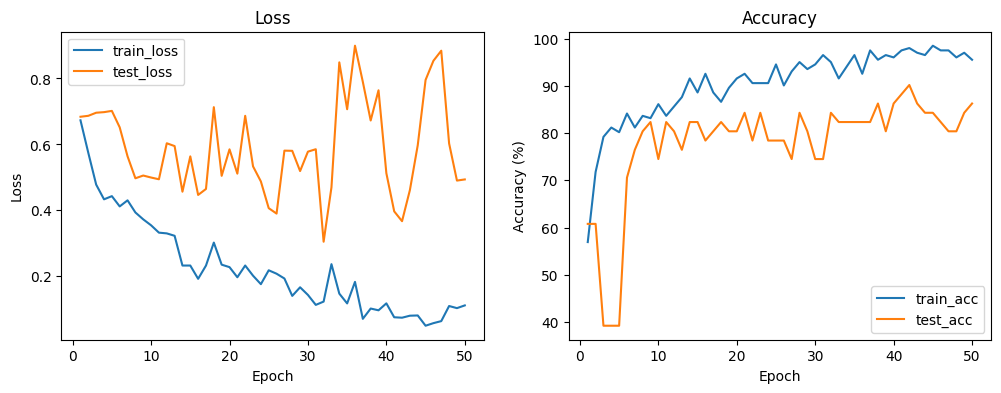

In [22]:

import matplotlib.pyplot as plt

def plot_history(history):
    epochs = history['epoch']
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, history['train_loss'], label='train_loss')
    plt.plot(epochs, history['test_loss'], label='test_loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.title('Loss')

    plt.subplot(1,2,2)
    plt.plot(epochs, [100*x for x in history['train_acc']], label='train_acc')
    plt.plot(epochs, [100*x for x in history['test_acc']], label='test_acc')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy (%)'); plt.legend(); plt.title('Accuracy')

    plt.show()

plot_history(history)


In [23]:
# Load best model checkpoint
best_model = BrainMRINet(num_classes=2, width_multiplier=0.5, depth_multiplier=0.5).to(device)
best_model.load_state_dict(torch.load('net_best.pth', map_location=device))

crit = nn.CrossEntropyLoss()
test_loss, test_acc = evaluate(best_model, val_loader, crit, device)
print(f"Best model test loss: {test_loss:.4f}, test acc: {100*test_acc:.2f}%")

Best model test loss: 0.3672, test acc: 90.20%


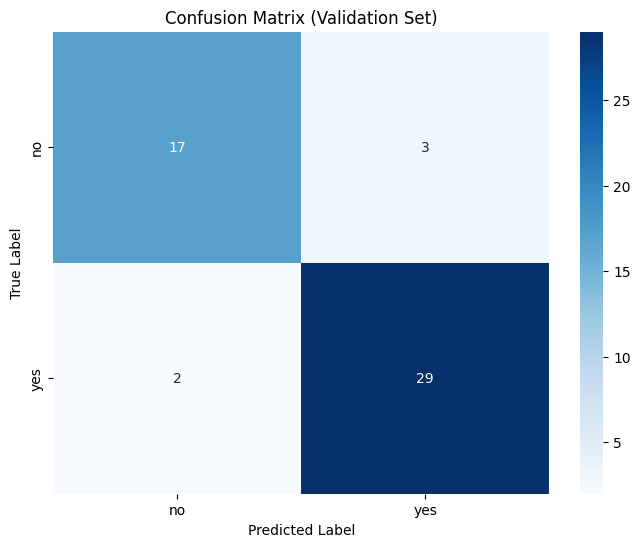

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Get predictions and true labels for the validation set
best_model.eval() # Set model to evaluation mode
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = best_model(images)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['no', 'yes'], yticklabels=['no', 'yes'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Validation Set)')
plt.show()

In [25]:
from sklearn.metrics import classification_report

target_names = ['no', 'yes']
print("\nClassification Report (Validation Set):")
print(classification_report(all_labels, all_preds, target_names=target_names))


Classification Report (Validation Set):
              precision    recall  f1-score   support

          no       0.89      0.85      0.87        20
         yes       0.91      0.94      0.92        31

    accuracy                           0.90        51
   macro avg       0.90      0.89      0.90        51
weighted avg       0.90      0.90      0.90        51



Found 5 misclassified images.


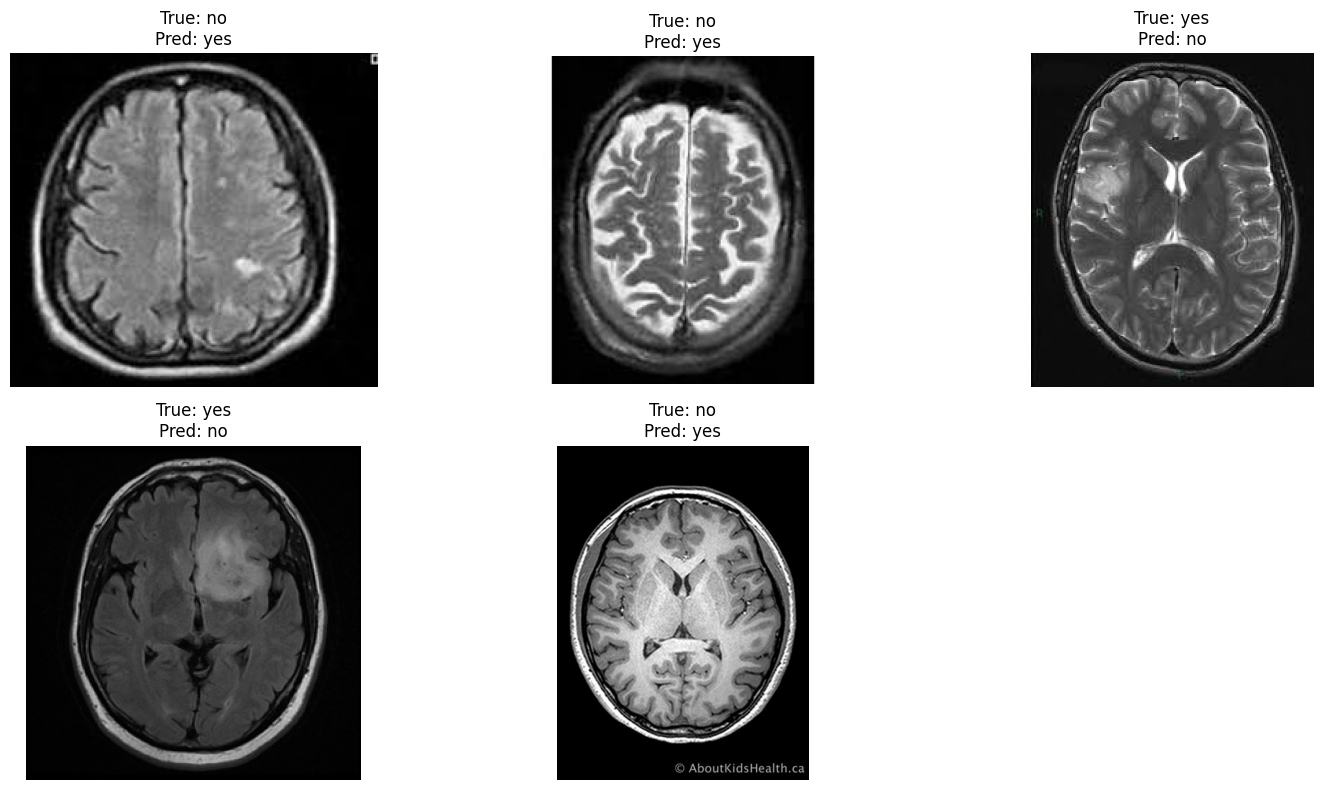

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import torch

best_model.eval()
misclassified_indices = []
with torch.no_grad():
    for i in range(len(val_dataset)):
        image, label = val_dataset[i]
        image = image.unsqueeze(0).to(device)
        output = best_model(image)
        pred = output.argmax(dim=1).item()

        if pred != label.item():
            misclassified_indices.append(i)

print(f"Found {len(misclassified_indices)} misclassified images.")

# Display some of the misclassified images
n_display = min(10, len(misclassified_indices))
plt.figure(figsize=(15, 8))
for i in range(n_display):
    idx = misclassified_indices[i]
    # Get the original image
    filepath = val_df.loc[idx, 'filepath']
    original_img = cv2.imread(filepath)
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

    true_label = 'yes' if val_dataset.labels[idx] == 1 else 'no'
    predicted_label = 'yes' if all_preds[idx] == 1 else 'no'

    plt.subplot(2, (n_display + 1) // 2, i + 1)
    plt.imshow(original_img)
    plt.title(f"True: {true_label}\nPred: {predicted_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()